In [17]:
import os, h5py
import numpy as np
from scipy import stats
from six.moves import cPickle
import matplotlib.pyplot as plt

In [18]:

def load_lentiMPRA_data(file):
    '''
    load Train/Test/Val lentiMPRA data
    '''
    data = h5py.File(file, 'r')

    # train
    X_train = np.array(data['Train']['X'])
    y_train = np.array(data['Train']['y'])

    # test
    X_test = np.array(data['Test']['X'])
    y_test = np.array(data['Test']['y'])

    # val
    X_val = np.array(data['Val']['X'])
    y_val = np.array(data['Val']['y'])

    return X_train, y_train, X_test, y_test, X_val, y_val


def gaussian_confidence_interval(pred, alpha=0.05):
    mean = pred[:,0]
    std_dev = np.sqrt(np.exp(pred[:,1]))
    z_score = stats.norm.ppf(1 - alpha / 2)
    lower_bound = mean - z_score * std_dev
    upper_bound = mean + z_score * std_dev
    return lower_bound, upper_bound


def laplace_confidence_interval(pred, alpha=0.05):
    mu = pred[:,0]
    b = np.exp(pred[:,1])
    lower_quantile = alpha / 2
    upper_quantile = 1 - alpha / 2
    lower_bound = mu - b * np.log(1 / lower_quantile)
    upper_bound = mu + b * np.log(1 / (1 - upper_quantile))
    return lower_bound, upper_bound


def cauchy_confidence_interval(pred, alpha=0.05):
    mu = pred[:,0]
    b = np.exp(pred[:,1])
    lower_quantile = alpha / 2
    upper_quantile = 1 - alpha / 2
    lower_bound = mu - b * np.tan(np.pi * (upper_quantile - 0.5))
    upper_bound = mu + b * np.tan(np.pi * (0.5 - lower_quantile))
    return lower_bound, upper_bound


def prediction_interval_coverage_probability(y, lower_bound, upper_bound):
    within_ci = sum(y[i] >= lower_bound[i] and y[i] <= upper_bound[i] for i in range(len(y)))    
    fraction = (within_ci / len(y)) 
    return fraction


def average_interval_length(upper_bound, lower_bound):
	interval_len = upper_bound - lower_bound
	avg_interval = np.mean(interval_len)
	std_interval = np.std(interval_len)
	return avg_interval, std_interval



In [20]:

num_trials = 10

results = {}
for cell_type in ['HepG2', 'K562']:

    filename = cell_type+'_data_with_aleatoric.h5'
    x_train, y_train, x_test, y_test, x_valid, y_valid = load_lentiMPRA_data(filename)
    N, L, A = x_valid.shape

    results[cell_type] = {}
    for loss_name in ['gaussian', 'laplace', 'cauchy']:
        results[cell_type][loss_name] = {}
        vals = []
        for trial in range(num_trials):
            save_path = 'lentiMPRA_'+cell_type+'_'+loss_name+'_'+str(trial)
            with open(save_path+'.pickle', 'rb') as fin:
                mse, pcc, scc = cPickle.load(fin)
                mse2, pcc2, scc2 = cPickle.load(fin)
                pred = cPickle.load(fin)
    
            if loss_name == 'gaussian':
                lower_bound, upper_bound = gaussian_confidence_interval(pred, alpha=0.05)
            elif loss_name == 'laplace':
                lower_bound, upper_bound = laplace_confidence_interval(pred, alpha=0.05)
            elif loss_name == 'cauchy':
                lower_bound, upper_bound = cauchy_confidence_interval(pred, alpha=0.05)
    
            fraction = prediction_interval_coverage_probability(y_test[:,0], lower_bound, upper_bound)
            avg_interval, std_interval = average_interval_length(upper_bound, lower_bound)
            vals.append([pcc, pcc2, fraction, avg_interval])
        results[cell_type][loss_name]['mean_pcc'] = np.array(vals)[:,0]
        results[cell_type][loss_name]['std_pcc'] = np.array(vals)[:,1]
        results[cell_type][loss_name]['fraction'] = np.array(vals)[:,2]
        results[cell_type][loss_name]['avg_interval'] = np.array(vals)[:,3]


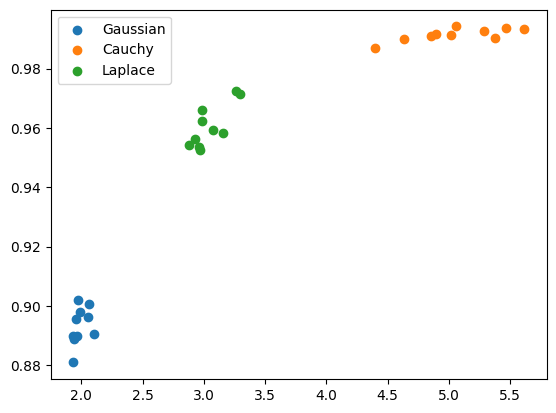

In [24]:
cell_type = 'HepG2'
val = results[cell_type]['gaussian']
plt.scatter(val['avg_interval'], val['fraction'])
val = results[cell_type]['cauchy']
plt.scatter(val['avg_interval'], val['fraction'])
val = results[cell_type]['laplace']
plt.scatter(val['avg_interval'], val['fraction'])
plt.legend(['Gaussian', 'Cauchy', 'Laplace'])

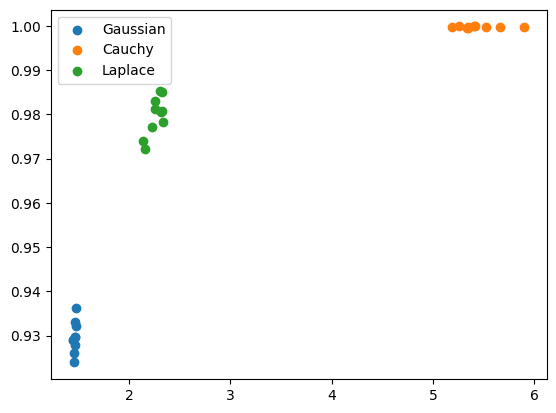

In [25]:
cell_type = 'K562'
val = results[cell_type]['gaussian']
plt.scatter(val['avg_interval'], val['fraction'])
val = results[cell_type]['cauchy']
plt.scatter(val['avg_interval'], val['fraction'])
val = results[cell_type]['laplace']
plt.scatter(val['avg_interval'], val['fraction'])
plt.legend(['Gaussian', 'Cauchy', 'Laplace'])

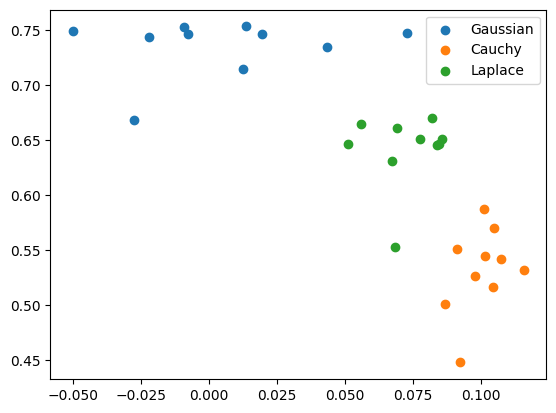

In [26]:
cell_type = 'HepG2'
val = results[cell_type]['gaussian']
plt.scatter(val['std_pcc'], val['mean_pcc'])
val = results[cell_type]['cauchy']
plt.scatter(val['std_pcc'], val['mean_pcc'])
val = results[cell_type]['laplace']
plt.scatter(val['std_pcc'], val['mean_pcc'])
plt.legend(['Gaussian', 'Cauchy', 'Laplace'])

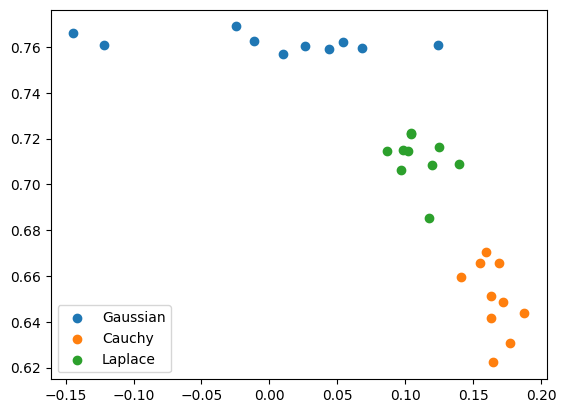

In [27]:
cell_type = 'K562'
val = results[cell_type]['gaussian']
plt.scatter(val['std_pcc'], val['mean_pcc'])
val = results[cell_type]['cauchy']
plt.scatter(val['std_pcc'], val['mean_pcc'])
val = results[cell_type]['laplace']
plt.scatter(val['std_pcc'], val['mean_pcc'])
plt.legend(['Gaussian', 'Cauchy', 'Laplace'])

In [28]:
with open('heteroscedastic_results.pickle', 'wb') as fout:
    cPickle.dump(results, fout)